In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [6]:
df = pd.read_csv('../inputs/train.csv')

In [7]:
global_filter = (df['return'] < 0.1) & (df['pf_category'] != 'E') & (df['type'] != 'G') & (df['bought'] < 1e10)

In [8]:
df = df.loc[global_filter, :]

In [9]:
df['indicator_code'] = df['indicator_code'].isnull().apply(lambda x: int(x))
hedge_value_dict = {True:1, False:0}
df['hedge_value'] = df['hedge_value'].apply(lambda x: hedge_value_dict[x] if x in hedge_value_dict else 2)

In [10]:
df['has_desk_id'] = df['desk_id'].isnull().apply(lambda x: int(x))
df['has_hedge_value'] = df['hedge_value'].apply(lambda x: 0 if x != 2 else 2)
df['status'] = df['status'].apply(lambda x: 1 if x == True else 0)

In [11]:
df['sell_year'] = df['sell_date'].apply(lambda x: x//10000)

In [12]:
df_pf_cat = df.groupby(['pf_category']).mean()['return'].reset_index().rename(columns = {'return':'pf_cat_mean'})
df = pd.merge(left = df, right = df_pf_cat, on = 'pf_category', how = 'left')

In [13]:
df_country = df.groupby(['country_code']).mean()['return'].reset_index().rename(columns = {'return':'country_mean'})
df = pd.merge(left = df, right = df_country, on = 'country_code', how = 'left')

In [14]:
df_type = df.groupby(['type']).mean()['return'].reset_index().rename(columns = {'return':'type_mean'})
df = pd.merge(left = df, right = df_type, on = 'type', how = 'left')

In [15]:
df_office = df.groupby(['office_id']).mean()['return'].reset_index().rename(columns = {'return':'office_mean'})
df = pd.merge(left = df, right = df_office, on = 'office_id', how = 'left')

In [80]:
print (df.dtypes)

portfolio_id        object
desk_id             object
office_id           object
pf_category         object
start_date           int64
sold               float64
country_code        object
euribor_rate       float64
currency            object
libor_rate         float64
bought             float64
creation_date        int64
indicator_code       int64
sell_date            int64
type                object
hedge_value          int64
status               int64
return             float64
has_desk_id          int64
has_hedge_value      int64
sell_year            int64
pf_cat_mean        float64
country_mean       float64
type_mean          float64
office_mean        float64
dtype: object


In [17]:
df['euribor_rate'].fillna(df['euribor_rate'].median(), inplace = True)
df['libor_rate'].fillna(df['libor_rate'].median(), inplace = True)

In [62]:
input_scale_cols = ['euribor_rate', 'libor_rate', 'pf_cat_mean', 'type_mean', 'country_mean', 'office_mean', 'sell_year']
input_other_cols = ['indicator_code', 'status']
target_col = ['return']

In [75]:
X = df[input_scale_cols + input_other_cols].as_matrix()
# scaler = StandardScaler()
# scaler.fit(X[:, 0:len(input_scale_cols)])
# X[:, 0:len(input_scale_cols)] = scaler.transform(X[:, 0:len(input_scale_cols)])

y = df[target_col].as_matrix()

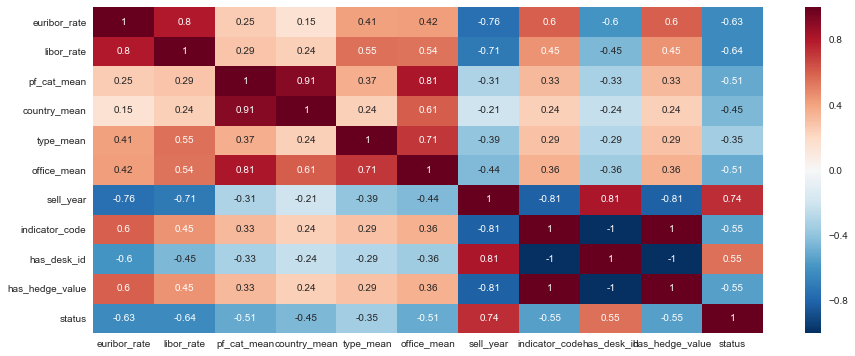

In [31]:
# fig, axs = plt.subplots(ncols = 3, figsize=(15, 6), gridspec_kw = {'width_ratios':[2, 1, 1]})
fig, axs = plt.subplots(ncols = 1, figsize=(15, 6))
sns.heatmap(df[input_scale_cols + input_other_cols].corr(), annot = True)

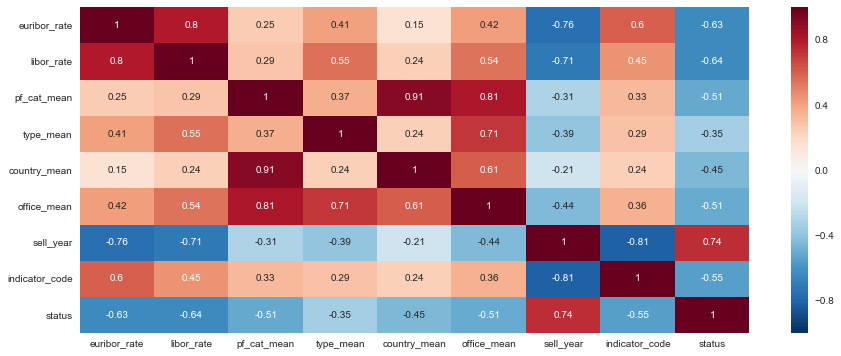

In [68]:
# fig, axs = plt.subplots(ncols = 3, figsize=(15, 6), gridspec_kw = {'width_ratios':[2, 1, 1]})
fig, axs = plt.subplots(ncols = 1, figsize=(15, 6))
sns.heatmap(df[input_scale_cols + input_other_cols].corr(), annot = True)

In [76]:
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [77]:
y_pred = model.predict(X)
print (r2_score(y, y_pred))

0.881339783631


In [58]:
for i in range(len(input_scale_cols) + len(input_other_cols)):
    if i < len(input_scale_cols):
        print (('%15s, %10f') % (input_scale_cols[i], model.coef_[0][i]))
    else:
        print (('%15s, %10f') % (input_other_cols[i-len(input_scale_cols)], model.coef_[0][i]))

   euribor_rate,   0.012214
     libor_rate,   0.002242
    pf_cat_mean,   0.017423
      type_mean,   0.001630
   country_mean,   0.000430
    office_mean,  -0.010418
      sell_year,   0.001606
 indicator_code,   0.003162
has_hedge_value,  -0.003830
         status,  -0.003557


In [108]:
model2 = RandomForestRegressor(n_estimators = 20, max_depth = 5, min_samples_split = 2, min_samples_leaf = 1,
                               random_state = 42)
model2.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [109]:
y_pred2 = model2.predict(X)
print (r2_score(y, y_pred2))

0.953209310257


In [106]:
for i in range(len(input_scale_cols) + len(input_other_cols)):
    if i < len(input_scale_cols):
        print (('%15s, %10f') % (input_scale_cols[i], model2.feature_importances_[i]))
    else:
        print (('%15s, %10f') % (input_other_cols[i-len(input_scale_cols)], model2.feature_importances_[i]))

   euribor_rate,   0.267645
     libor_rate,   0.033016
    pf_cat_mean,   0.018038
      type_mean,   0.005938
   country_mean,   0.159927
    office_mean,   0.009513
      sell_year,   0.016085
 indicator_code,   0.000010
         status,   0.489830


In [ ]:
# xgboost parameter tuning

In [82]:
input_cols_xgb_encode = ['pf_category', 'country_code', 'type'] 
input_cols_xgb_numeric = ['sold', 'euribor_rate', 'libor_rate', 'indicator_code',\
                          'hedge_value', 'status', 'has_desk_id', 'has_hedge_value', \
                          'sell_year', 'pf_cat_mean', 'country_mean', 'type_mean', 'office_mean']
target_cols_xgb = ['return']

In [91]:
X_xgb = df[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()
label_enc = [LabelEncoder() for i in range(len(input_cols_xgb_encode))]

for i in range(len(label_enc)):
    label_enc[i].fit(X_xgb[:, i])
    X_xgb[:, i] = label_enc[i].transform(X_xgb[:, i])

y_xgb = df[target_cols_xgb].as_matrix()

In [112]:
# get the optimum no of trees for learning rate of 0.1
parameters = {'n_estimators' : [50, 100, 250, 500]}
xgb_reg = XGBRegressor(random_state=42)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'n_estimators': 500}


In [111]:
pd.DataFrame(clf.cv_results_)
# take 500 trees as the optimum number for now

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.141556,0.003664,0.309532,0.941986,50,{'n_estimators': 50},4,-0.082359,0.941056,0.929445,0.935847,0.081437,0.949056,0.020516,0.000246,0.443450,0.005432
1,0.239019,0.007005,0.442048,0.970463,100,{'n_estimators': 100},3,0.204032,0.982977,0.960509,0.961487,0.161512,0.966925,0.006079,0.000819,0.367048,0.009123
2,0.597740,0.021222,0.502388,0.976403,250,{'n_estimators': 250},2,0.280265,0.987873,0.960400,0.968225,0.266424,0.973112,0.012579,0.004511,0.323938,0.008352
3,1.037266,0.032705,0.504913,0.979928,500,{'n_estimators': 500},1,0.280331,0.987883,0.961434,0.973530,0.272900,0.978371,0.173010,0.006969,0.322849,0.005962


In [114]:
# now tune the max_depth and min_child_weight
parameters = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'max_depth': 5, 'min_child_weight': 1}


In [115]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.074245,0.032755,0.504913,0.979928,3,1,"{'max_depth': 3, 'min_child_weight': 1}",2,0.280331,0.987883,0.961434,0.973530,0.272900,0.978371,0.164475,0.008259,0.322849,0.005962
1,1.139825,0.032083,0.446633,0.978943,3,3,"{'max_depth': 3, 'min_child_weight': 3}",7,0.119070,0.987398,0.958779,0.972838,0.261992,0.976594,0.165892,0.007785,0.366840,0.006172
2,1.096967,0.031909,0.449753,0.978069,3,5,"{'max_depth': 3, 'min_child_weight': 5}",6,0.127411,0.986431,0.959370,0.972307,0.262418,0.975467,0.181554,0.008001,0.364573,0.006052
3,1.031875,0.030595,0.544650,0.983731,5,1,"{'max_depth': 5, 'min_child_weight': 1}",1,0.428079,0.990975,0.957681,0.978131,0.248095,0.982086,0.142822,0.012042,0.301181,0.005371
4,1.046716,0.023887,0.463073,0.982232,5,3,"{'max_depth': 5, 'min_child_weight': 3}",5,0.179763,0.988862,0.957795,0.977449,0.251592,0.980387,0.158754,0.007809,0.351076,0.004839
5,1.162114,0.028429,0.464412,0.980418,5,5,"{'max_depth': 5, 'min_child_weight': 5}",4,0.191479,0.987817,0.953541,0.974855,0.248147,0.978582,0.313595,0.009503,0.346667,0.005449
6,1.049984,0.020398,0.465373,0.985931,7,1,"{'max_depth': 7, 'min_child_weight': 1}",3,0.160015,0.993235,0.954319,0.980492,0.281725,0.984067,0.042233,0.005105,0.349317,0.005367
7,1.001414,0.024079,0.354743,0.983902,7,3,"{'max_depth': 7, 'min_child_weight': 3}",8,-0.114273,0.990656,0.953616,0.979376,0.224844,0.981675,0.117621,0.010846,0.445555,0.004867
8,1.123686,0.021201,0.341524,0.982809,7,5,"{'max_depth': 7, 'min_child_weight': 5}",10,-0.156643,0.990304,0.956231,0.977926,0.224947,0.980196,0.134694,0.006143,0.461768,0.005381
9,1.038783,0.017716,0.342614,0.987119,9,1,"{'max_depth': 9, 'min_child_weight': 1}",9,-0.175712,0.994050,0.956006,0.982282,0.247518,0.985023,0.026972,0.003893,0.466913,0.005027


In [116]:
# check the values in the neighbourhood of the above values
parameters = {
 'max_depth':[4, 5, 6],
 'min_child_weight':[1,2]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'max_depth': 5, 'min_child_weight': 1}


In [117]:
# tune the value of gamma
parameters = {
 'gamma':[x/10.0 for x in range(6)]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500, \
                       max_depth = 5, min_child_weight = 1)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'gamma': 0.0}


In [119]:
# tune the value of subsample and colsample_bytree
parameters = {
 'subsample':[x/10.0 for x in range(6,11)],
 'colsample_bytree':[x/10.0 for x in range(6,11)]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500, \
                       max_depth = 5, min_child_weight = 1, gamma = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'colsample_bytree': 0.8, 'subsample': 0.9}


In [120]:
# tune the value of subsample and colsample_bytree with more tight intervals
parameters = {
 'subsample':[0.85, 0.9, 0.95],
 'colsample_bytree':[0.75, 0.8, 0.85]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500, \
                       max_depth = 5, min_child_weight = 1, gamma = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'colsample_bytree': 0.85, 'subsample': 0.95}


In [122]:
# tune regularization value alpha
parameters = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500, \
                       max_depth = 5, min_child_weight = 1, gamma = 0, \
                       colsample_bytree = 0.85, subsample = 0.95)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'reg_alpha': 1e-05}


In [130]:
# tune the learning rate
parameters = {
 'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.3]
}
xgb_reg = XGBRegressor(random_state=42, n_estimators = 1000, \
                       max_depth = 5, min_child_weight = 1, gamma = 0, \
                       colsample_bytree = 0.85, subsample = 0.95)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'learning_rate': 0.1}


In [134]:
# train the final classifier
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 500, \
                       max_depth = 5, min_child_weight = 1, gamma = 0, \
                       colsample_bytree = 0.85, subsample = 0.95)
xgb_reg.fit(X_xgb, y_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.95)

In [135]:
y_xgb_pred = xgb_reg.predict(X_xgb)
print (r2_score(y, y_xgb_pred))

0.987682344643


In [133]:
# make predictions on the test set with the optimum parameters
X_xgb_test = df_test[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()

for i in range(len(label_enc)):
    X_xgb_test[:, i] = label_enc[i].transform(X_xgb_test[:, i])


df_submit = pd.DataFrame(df_test['portfolio_id'])
df_submit['return'] = xgb_reg.predict(X_xgb_test)

df_submit.to_csv('../submissions/submit_20171216_1729_xgb.csv', index=False)


In [27]:
# make predictions on the test set
df_test = pd.read_csv('../inputs/test.csv')

df_test['indicator_code'] = df_test['indicator_code'].isnull().apply(lambda x: int(x))
df_test['hedge_value'] = df_test['hedge_value'].apply(lambda x: hedge_value_dict[x] if x in hedge_value_dict else 2)

df_test['has_desk_id'] = df_test['desk_id'].isnull().apply(lambda x: int(x))
df_test['has_hedge_value'] = df_test['hedge_value'].apply(lambda x: 0 if x != 2 else 2)
df_test['status'] = df_test['status'].apply(lambda x: 1 if x == True else 0)

df_test['sell_year'] = df_test['sell_date'].apply(lambda x: x//10000)

df_test['euribor_rate'].fillna(df['euribor_rate'].median(), inplace = True)
df_test['libor_rate'].fillna(df['libor_rate'].median(), inplace = True)

df_test = pd.merge(left = df_test, right = df_pf_cat, on = 'pf_category', how = 'left')
df_test = pd.merge(left = df_test, right = df_country, on = 'country_code', how = 'left')
df_test = pd.merge(left = df_test, right = df_type, on = 'type', how = 'left')
df_test = pd.merge(left = df_test, right = df_office, on = 'office_id', how = 'left')

In [28]:
print (df_test.columns)

Index(['portfolio_id', 'desk_id', 'office_id', 'pf_category', 'start_date',
       'sold', 'country_code', 'euribor_rate', 'currency', 'libor_rate',
       'bought', 'creation_date', 'indicator_code', 'sell_date', 'type',
       'hedge_value', 'status', 'has_desk_id', 'has_hedge_value', 'sell_year',
       'pf_cat_mean', 'country_mean', 'type_mean', 'office_mean'],
      dtype='object')


In [107]:
X_test = df_test[input_scale_cols + input_other_cols].as_matrix()
X_test[:, 0:len(input_scale_cols)] = scaler.transform(X_test[:, 0:len(input_scale_cols)])

df_submit = pd.DataFrame(df_test['portfolio_id'])
df_submit['return'] = model.predict(X_test)

df_submit.to_csv('../submissions/submit_20171216_1632_rf.csv', index=False)